# Prueba 1: Análisis de Sentimientos de Twitter

## PRELIMINARES

El ejercicio tiene por objetivo clasificar los sentimientos de tweets realizados en la red social Twitter, por lo tanto es un problema de clasificación. Para ello, se tiene una cantidad de sentimientos, los cuáles se deben re categorizar como sentimientos positivos o negativos. El problema consiste en que se tiene una serie de textos pertenecientes a estos tweets, los cuales deben ser analizados por el contenido de sus palabras, en donde la palabra será el atributo que nos permitirá predecir, mediante un modelo predictivo de clasificación, si el sentimiento es positivo o negativo en base al contenido del texto.

La solución al problema constará de un pre procesamiento, en donde se aplicará un vectorizador de textos, con el propósito de poder trabajar de mejor forma con las palabras contenidas. Luego, se va a definir cuáles son las palabras que más influyen en la predicción de los sentimientos y en base a estas se aplicarán los modelos de clasificación escogidos.

Los modelos de clasificación que se aplicarán para la resolución del problema son los siguientes:
* Naive Bayes.
* Regresión logística.
* Máquinas de soporte vectorial (SVC)
* Boosting Machines (GradientBoosting).
* Mecanismo de votación.

Para que estos modelos funcionen de una manera más óptima y mejorar sus métricas, se implementará una búsqueda de grilla y Pipeline con el propósito de encontrar los mejores hiper parámetros para cada modelo aplicado. Con esto y el pre procesamiento se espera optimizar el modelo implementado y escoger los dos que entreguen las mejores métricas.

Finalmente, las métricas serán la matriz de confusión, el reporte de clasificación con métricas de precision, recall y f1 score y la curva ROC.

## Hito 1: Aspectos Computacionales

In [151]:
# Importación de librerías básicas para el pre procesamiento y procesamiento de datos.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import random
random.seed(2208)

#Importación para la aplicación de modelos en SkLearn.
from sklearn.model_selection import train_test_split as TTS
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

#Importación de métricas de desempeño de SkLearn para evaluar los modelos.
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

import pandas_profiling

Se importa la base de datos proporcionada con los tweets, para realizar el análisis:

In [152]:
df = pd.read_csv("training_tweets.csv").drop(columns="Unnamed: 0")
df

content  sentiment
0                        Happy Mama's day to all mothers       love
1      @LysdelTellez I am lost. Please help me find a...      worry
2      @BoomKatt yes yes I AM, networking whore to th...  happiness
3      you@snapplynn Wish that would have been your t...    neutral
4      now i am doing the MicroEconomics project  iha...      worry
...                                                  ...        ...
29995                   I  do not want to work tomorrow!    sadness
29996  @KandyBee we shuld do  a dance like that its s...        fun
29997  Photo: Got my prints a few days ago, ready for...  happiness
29998            @tove_liden Thanks for the follow Tove!        fun
29999                                 @esmeeworld thanks    neutral

[30000 rows x 2 columns]

<AxesSubplot: xlabel='sentiment', ylabel='count'>

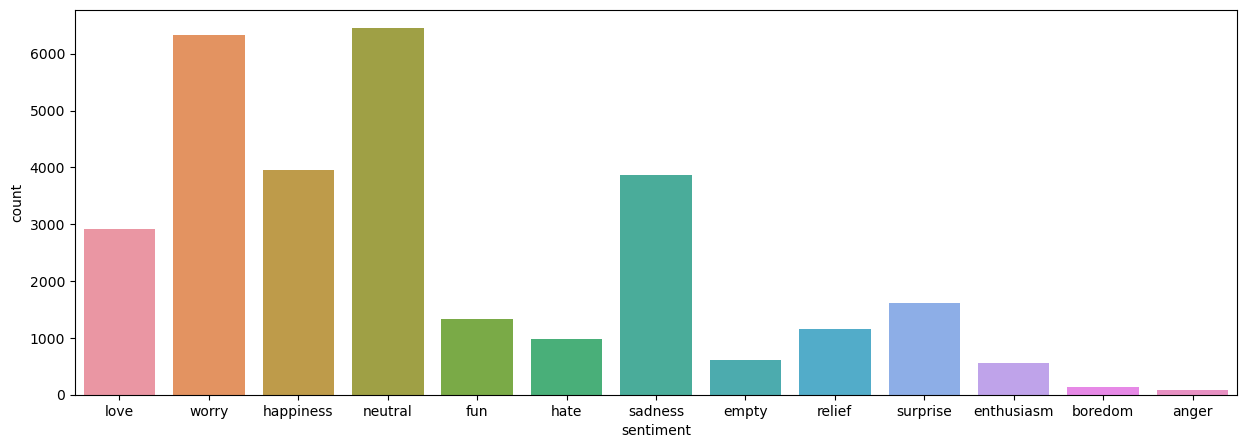

In [153]:
plt.figure(figsize=(15,5))
sns.countplot(x=df["sentiment"])

Se crea la variable sentiment_bin, asignando segun las indicaciones los valores "Positiva" y "Negativa" segun corresponda. Para el caso de valores "neutral", se asignan de manera aleatoria

In [154]:
positive = ["happiness", "love", "surprise", "fun", "relief", "enthusiasm"]
df["sentiment_bin"] = np.where(df["sentiment"].isin(positive), "Positiva", "Negativa")

df["sentiment_bin"] = np.where(df["sentiment"] == "neutral", random.choice(["Positiva", "Negativa"]), df["sentiment_bin"])

          sentiment_bin
Positiva          17978
Negativa          12022


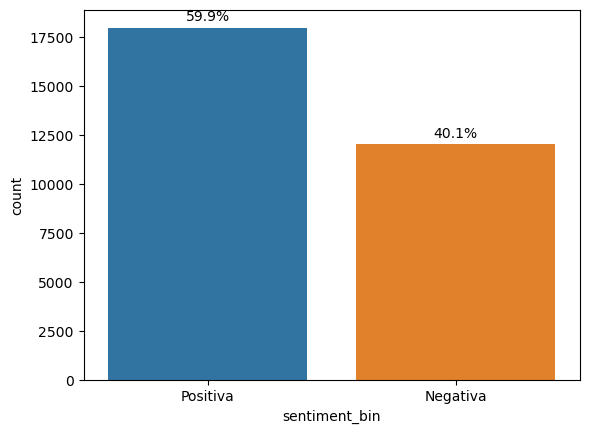

In [155]:
ax = sns.countplot(x=df["sentiment_bin"])
for p in ax.patches:
    height = p.get_height()
    ax.annotate("{:.1f}%".format(height*100/df["sentiment_bin"].shape[0]),
                xy=(p.get_x()+p.get_width()/2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha="center", va="bottom")
    
print(df["sentiment_bin"].value_counts().to_frame())

Se observa una desbalance de un 10% aproximadamente entre sentimientos Positivos y Negativos (proporcion ~ 60/40)

Se convierte a lower case los tweets.


In [156]:
df["content"] = df["content"].str.lower()
df

content  sentiment  \
0                        happy mama's day to all mothers       love   
1      @lysdeltellez i am lost. please help me find a...      worry   
2      @boomkatt yes yes i am, networking whore to th...  happiness   
3      you@snapplynn wish that would have been your t...    neutral   
4      now i am doing the microeconomics project  iha...      worry   
...                                                  ...        ...   
29995                   i  do not want to work tomorrow!    sadness   
29996  @kandybee we shuld do  a dance like that its s...        fun   
29997  photo: got my prints a few days ago, ready for...  happiness   
29998            @tove_liden thanks for the follow tove!        fun   
29999                                 @esmeeworld thanks    neutral   

      sentiment_bin  
0          Positiva  
1          Negativa  
2          Positiva  
3          Positiva  
4          Negativa  
...             ...  
29995      Negativa  
29996      Positiva  
29997      Positiva  
29998      Positiva  
29999      Positiva  

[30000 rows x 3 columns]

Se analizan los datos perdidos

In [162]:
df.isnull().sum()

content          0
sentiment        0
sentiment_bin    0
dtype: int64

# Grilla Maquinas de Soporte Vectorial

C: [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
gamma: [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
Validaciones cruzadas: 10.

# Naive Bayes
alpha = [0.5, 1 ,2]

# GradientBoostingClassifier

learning_rate: [0.01, 0.1, 0.5],
n_estimators: [50, 100, 500, 1000, 2000]
subsample: [0.1,0.5,0.9]

# LogisticRegression

C: [0.01,0.1,1,10,100]
fit_intercept: [ True, False]

# Estimadores Voting

estimators = [('Logistic Regression', LogisticRegression()),
             ('SVM', SVC()),
             ('Naive Bayes', MultinomialNB()),
              ('Boosting Machine', GradientBoosting())]

In [ ]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ltper\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True